# RED NEURONAL.

El objetivo de este trabajo es armar una red neuronal que pueda predecir la siguiente nota. Se elaboraron tres modelos, el basico donde se trabajo primeramente, el siguiente modelo armado con la funcion de activacion softmax y el modelo armado con tensorflow que sirvio de control.

La base de datos elegida es un conjunto de datos que contiene alrededor de 200hs de grabaciones de audio y MIDI emparejadas de diez años de Concurso Internacional de Piano.

FUENTE: https://magenta.tensorflow.org/datasets/maestro

- Aclaracion: Este modelo fue el modelo original, en el cual se obtuvieron los primeros errores y un armado base de la red.

In [ ]:
# import zipfile as zf
# files = zf.ZipFile("/content/maestro-v3.0.0-midi.zip", 'r')
# files.extractall('data/')
# files.close()
!pip install pretty_midi
!pip install tensorflow
!pip install scikit-learn

Se instalan todos los paquetes relevantes para procesar y escuchar archivos MIDI, glob para iterar sobre los archivos del dataset, collections para el diccionario con valor por defecto, y pathlib para abrir el archivo.

In [69]:
import collections
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import tensorflow as tf
import itertools
from sklearn.model_selection import train_test_split

Se define un directorio que contendra todos los archivos MIDI que seran analizados. Se arma una funcion que convierte esos archivos a un DataFrame de pandas donde utilizamos una variable para definir una "nota" que contendra como caracteristica el tono (pitch). Tono es la calidad sonora de la nota, lo que la distingue de otras.

In [70]:
np.random.seed(0)
directorio = pathlib.Path('data/maestro-v2.0.0')
if not directorio.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

filenames = glob.glob(str(directorio/'**/*.mid*'))
print('num archivos:', len(filenames))

# sample_file = "/content/MIDI-Unprocessed_25_R2_2011_MID--AUDIO_R2-D6_07_Track07_wav.midi"
# print(sample_file)

def midi_a_notas(midifile: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midifile)
    instrumento = pm.instruments[0]
    notas = collections.defaultdict(list)

    notas_orden = sorted(instrumento.notes, key=lambda nota: nota.start)
    previa_inicio = notas_orden[0].start

    for nota in notas_orden:
        notas['pitch'].append(nota.pitch)

    return pd.DataFrame({nombre: np.array(valor) for nombre, valor in notas.items()})

num archivos: 1282


Se agrega un fragmento de codigo hecho por otra persona, que permite escribir un dataframe con notas en un archivo midi y lo devuelve como prettyMIDI para poder escucharlo (No se usa):

In [71]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

Se procesan los archivos MIDI, se extraen las notas de cada archivo y se preparan los datos para el modelo del aprendizaje automatico mas adelante.

In [72]:
notasGlobal = []
tam_muestra = 2

for f in filenames[:tam_muestra]:
  notas = midi_a_notas(f)
  notasGlobal.append(notas)

notasGlobal = pd.concat(notasGlobal)
print(notasGlobal.head())

indice_notas = ['pitch']
notas_entrenamiento = np.array([notasGlobal[key] for key in indice_notas]).flatten()
np.set_printoptions(precision=3)
dataset_nota = tf.data.Dataset.from_tensor_slices(notas_entrenamiento)
print(notas_entrenamiento)
#print(list(dataset_nota.as_numpy_iterator()))

   pitch
0     30
1     35
2     36
3     37
4     38
[30 35 36 ... 63 68 75]


Luego, transformamos el dataset de las notas en ventanas de secuencias para su uso.

In [73]:
def ventanizar(dataset, tam_ventana, alfabeto_notas = 128,) -> tf.data.Dataset:
  tam_ventana = tam_ventana + 1

  windows = dataset.window(tam_ventana, shift=1, stride=1, drop_remainder=True)
  flatten = lambda x: x.batch(tam_ventana, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize tono de las notas
  def normalizar_tono(x):
    x = x/alfabeto_notas
    return x

  # Partimos los indices
  def partir_indices(sequences):
    inputs = sequences[:-1]
    outputs_dense = sequences[-1]
    return normalizar_tono(inputs), outputs_dense
  return sequences.map(partir_indices,num_parallel_calls=tf.data.AUTOTUNE)

ventanitas = ventanizar(dataset_nota, 100)
dataset_pandas = pd.DataFrame(list(ventanitas.as_numpy_iterator()), columns=['inputs','output'])
dataset_pandas.head()

,inputs,output
0,"[0.234375, 0.2734375, 0.28125, 0.2890625, 0.29...",50
1,"[0.2734375, 0.28125, 0.2890625, 0.296875, 0.30...",47
2,"[0.28125, 0.2890625, 0.296875, 0.3046875, 0.31...",35
3,"[0.2890625, 0.296875, 0.3046875, 0.3125, 0.320...",30
4,"[0.296875, 0.3046875, 0.3125, 0.3203125, 0.328...",35


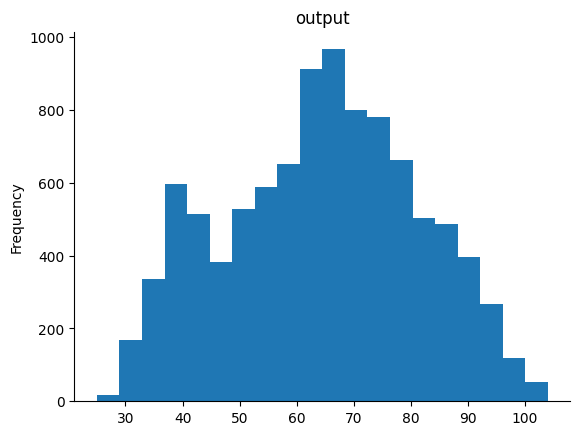

In [74]:
# @title output

from matplotlib import pyplot as plt
dataset_pandas['output'].plot(kind='hist', bins=20, title='output')
plt.gca().spines[['top', 'right',]].set_visible(False)

Preparacion de los datos para trabajar con la red. Se separa el split de la base de datos de la red propiamente dicha para que se entrene la red siempre con los mismos datos.

In [75]:
# neuronas_entrada = 100 / neuronas_de_la_capa_oculta = 60 / neurona_salida = 1

# Extraemos los datos de entrada y de salida
inputs = np.array(dataset_pandas['inputs'].tolist())
output = np.array(dataset_pandas['output'])

# Separar un conjunto de datos para entrenar y otro para probar
x_train, x_test, y_train, y_test = train_test_split(inputs, output, test_size=1/3)

Se inicializan las variables y se definen las funciones para el entrenamiento de la red. Se deja todo optimo para entrenar la red.

In [76]:
# Pesos y sesgos
w_hidden = np.random.rand(60, 100) * 2 - 1
w_output = np.random.rand(1, 60) * 2 - 1
b_hidden = np.random.rand(60, 1) * 2 - 1
b_output = np.random.rand(1, 1) * 2 - 1

# Funcion de activacion y la derivada
relu = lambda x: np.where(x > 0, x, 0.01 * x)
logistic = lambda x: 1 / (1 + np.exp(-x))
d_relu = lambda x: np.where(x > 0, 1, 0.01)
d_logistic = lambda x: np.exp(-x) / (1 + np.exp(-x)) ** 2

# Forward Propagation, recorrer la red hacia adelante
def forward_prop(x):
	z1 = np.matmul(w_hidden, x).reshape((60,1)) + b_hidden
	a1 = relu(z1)
	z2 = np.matmul(w_output, a1) + b_output
	a2 = logistic(z2)
	return z1, a1, z2, a2

# Backpropagation, recorrer la red hacia atras
def backward_prop(z1, a1, z2, a2, x, y):
	dc_da2 = 2 * a2*128 - 2 * y
	da2_dz2 = d_logistic(z2)
	dz2_da1 = w_output
	dz2_dw2 = a1
	dz2_db2 = 1
	da1_dz1 = d_relu(z1)
	dz1_dw1 = x
	dz1_db1 = 1

	dc_dw2 = dc_da2 @ da2_dz2 @ dz2_dw2.T
	dc_db2 = dc_da2 @ da2_dz2 * dz2_db2
	dc_da1 = dc_da2 @ da2_dz2 @ dz2_da1
	dc_dw1 = dc_da1 @ da1_dz1 @ dz1_dw1.T
	dc_db1 = dc_da1 @ da1_dz1 * dz1_db1

	return dc_dw1, dc_db1, dc_dw2, dc_db2

Se define el calculo de precision para el test y el train. Tambien se calcula el accuracy antes de entrenar la red.

In [83]:
# Calculo de precision, calculo muchas precisiones individuales y las promedio.
def calcular_accuracy():
  accuracy_train = 0
  accuracy_test = 0
  #np.set_printoptions(precision=5, suppress=True)
  iters = 1000
  for i in range(iters):
    idx = np.random.randint(0, len(x_test))
    test_predictions = forward_prop(x_test[idx].T)[3]*128
    accuracy_individual_test =  ((test_predictions - y_test[idx]).astype(int))**2
    accuracy_test += accuracy_individual_test

    jdx = np.random.randint(0, len(x_train))
    train_predictions = forward_prop(x_train[jdx].T)[3]*128
    accuracy_individual_train =  ((train_predictions - y_train[jdx]).astype(int))**2
    accuracy_train += accuracy_individual_train

  return accuracy_test.flatten()[0].astype(np.float32) / iters, accuracy_train.flatten()[0].astype(np.float32) / iters

# Se muestra el valor del accuracy antes del entrenamiento
valor_test, valor_train = calcular_accuracy()
print("ACCURACY TEST:", valor_test)
print("ACCURACY TRAIN:", valor_train)

ACCURACY TEST: 4336.464
ACCURACY TRAIN: 4412.612


Se arma la funcion que grafica los valores de accuracy

In [78]:
def graficar_accuracy(L, train_l, test_l):
    #print(train_l)
    #print(test_l)
    iters = len(test_l)
    fmt_train = {
        'color': 'tab:blue',
        'ls': 'solid',
        'lw': 3,
    }
    fmt_test = {
        'color': 'tab:orange',
        'ls': 'solid',
        'lw': 3,
    }

    fig, (ax) = plt.subplots(1, 1, figsize = (10, 8))

    ax.plot(train_l, label = 'Train', **fmt_train)
    ax.plot(test_l, label = 'Test', **fmt_test)

    ax.grid(which='both')
    ax.legend()
    ax.set_title(f'Accuracy {L=}')
    ax.set_xlabel(f'Iters {iters=}')

    fig.tight_layout()
    plt.savefig(f'accuracy_{L=}_{iters=}.png')

Se define una funcion que contiene el entrenamiento de la red neuronal para asi encontrar los valores mas optimos para la misma. La red ya esta definida para la utilizacion de todas las variables y funciones declaradas anteriormente.


In [79]:
def red_neuronal (L, epoch, w_hidden, w_output, b_hidden, b_output, relu, logistic, d_relu, d_logistic):

  accuracy_test_l = []
  accuracy_train_l = []
  # Ejecutar descenso de gradiente
  for i in range(epoch):
    # Seleccion aleatoria de unos de los datos de entrenamiento
    idx = [np.random.randint(0,len(x_train))]
    x_sample = x_train[idx].T
    y_sample = y_train[idx]

    # Pasar los datos seleccionados a traves de la red
    z1, a1, z2, a2 = forward_prop(x_sample)
    # Distribuir el error a traves de la retro propagacion, devolver pendientes para pesos y sesgo
    dw_hidden, db_hidden, dw_output, db_output = backward_prop(z1, a1, z2, a2, x_sample, y_sample)

    # Actualizar pesos y sesgos
    w_hidden -= L * dw_hidden
    b_hidden -= L * db_hidden
    w_output -= L * dw_output
    b_output -= L * db_output

    accuracy_test, accuracy_train = calcular_accuracy()
    accuracy_test_l.append(accuracy_test)
    accuracy_train_l.append(accuracy_train)

  graficar_accuracy(L=L,train_l=accuracy_train_l, test_l=accuracy_test_l)

  #print(dw_hidden, b_hidden, w_output, b_output, sep="\n")
  #print("\n\n")


Ahora se prueba la red neuronal, modificando las variables de la taza de aprendizaje y las iteraciones que da.

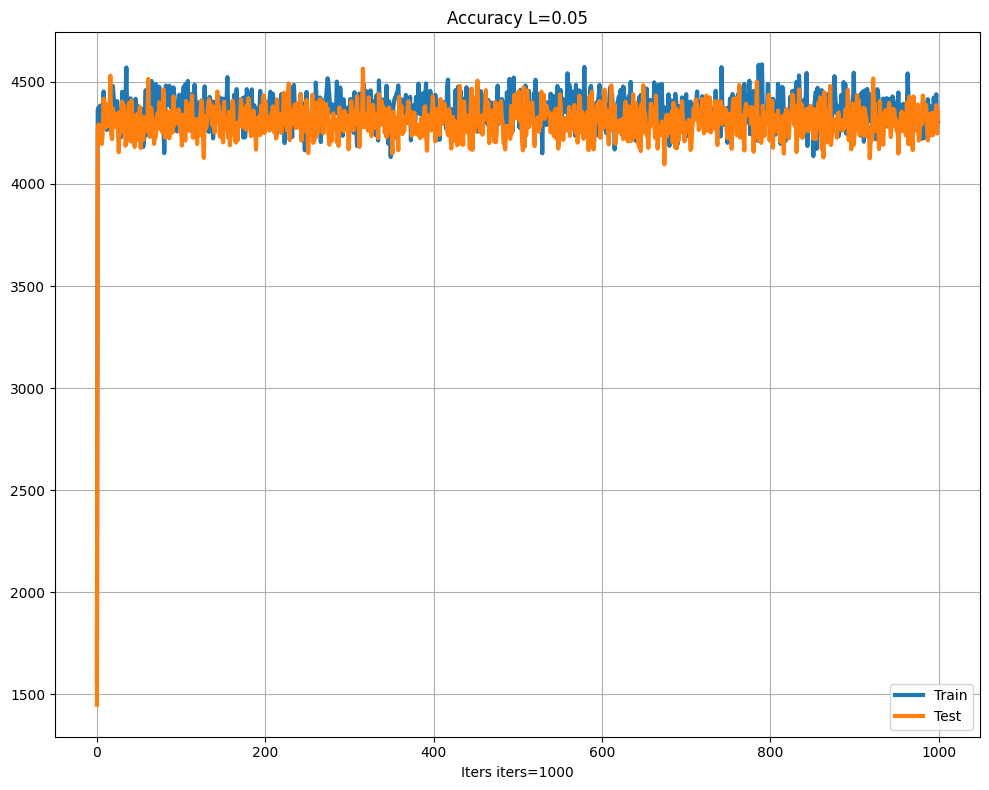

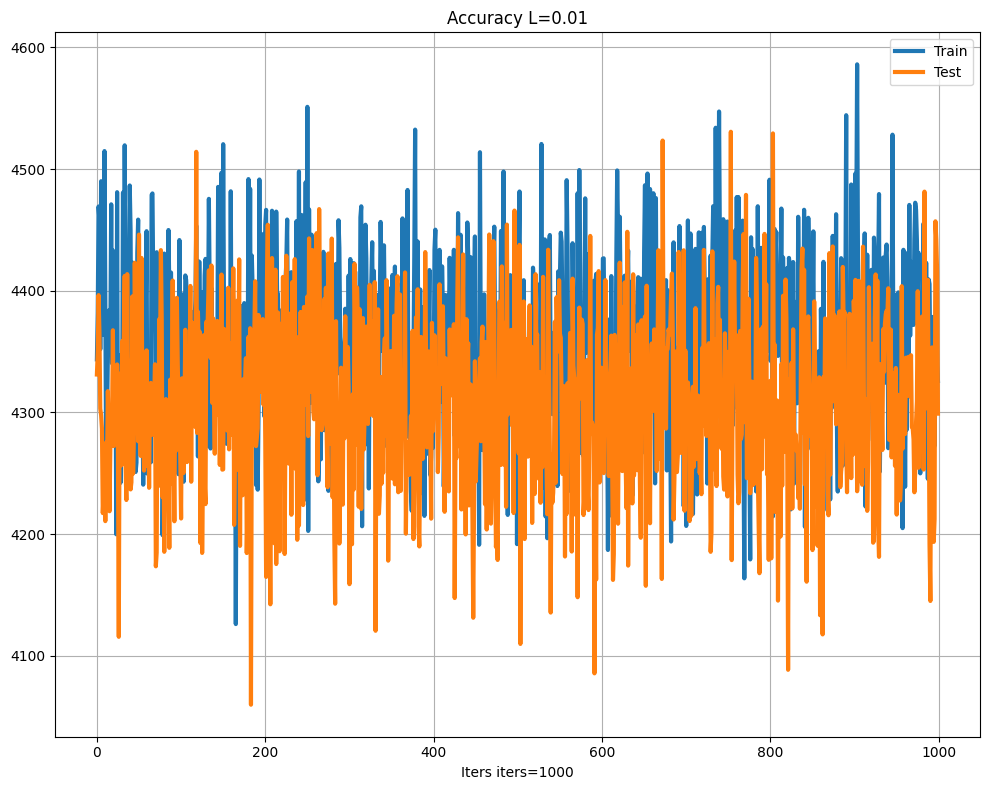

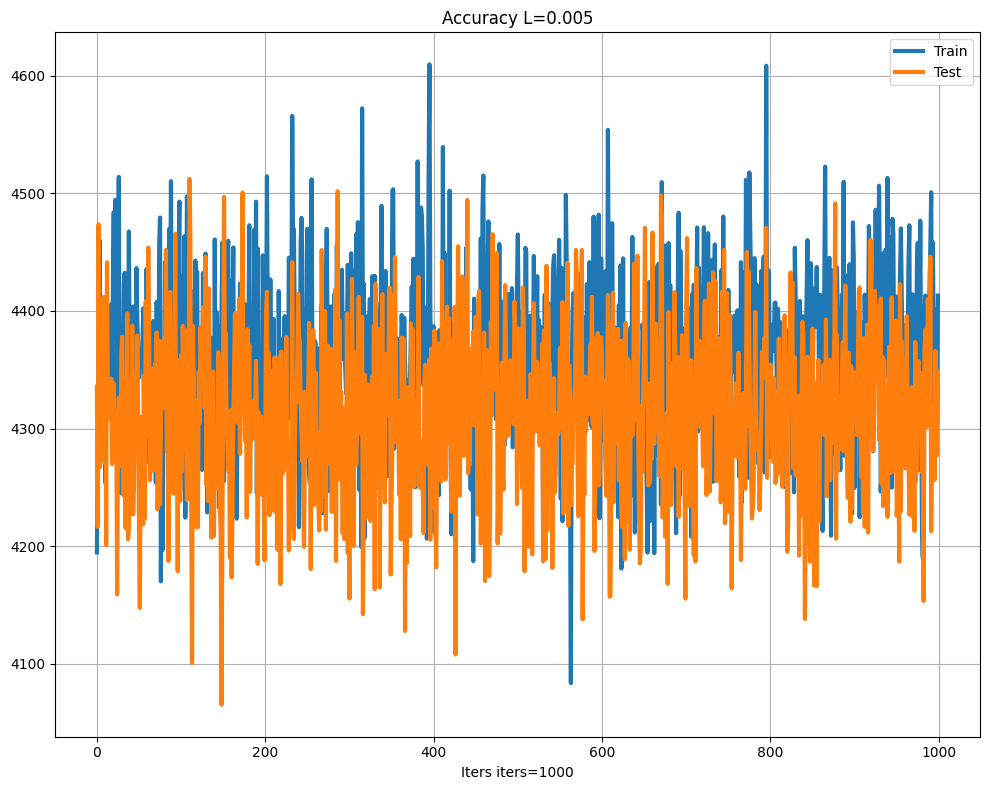

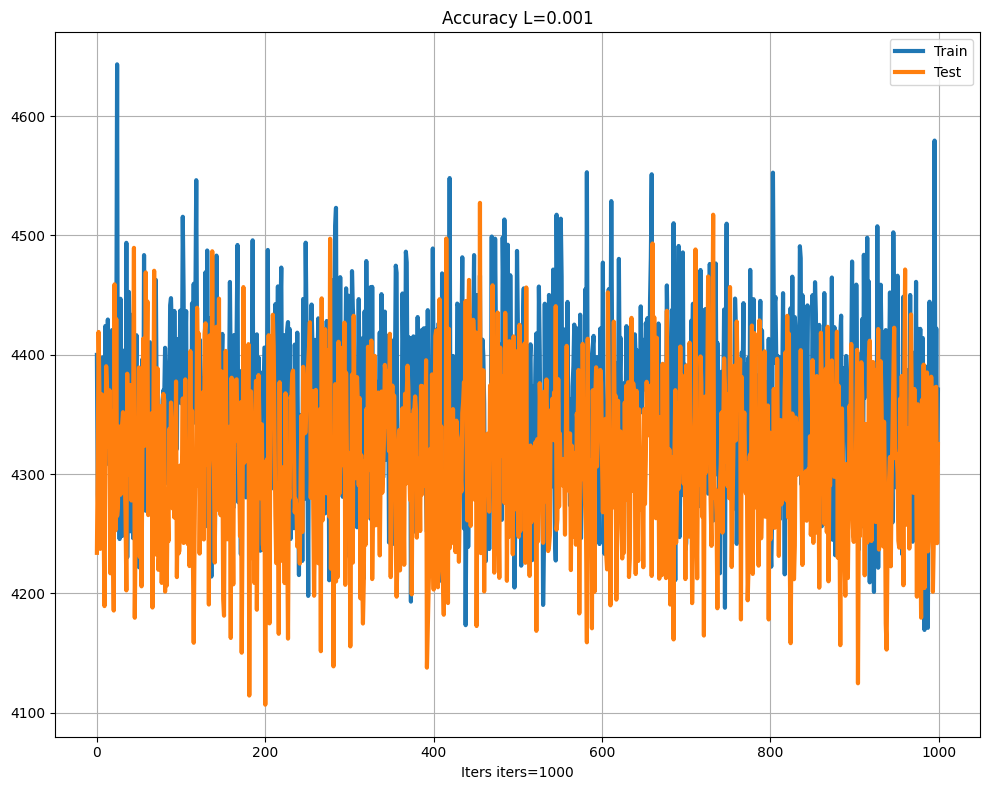

In [80]:
iter = 1000
L_l = [0.05, 0.01, 0.005, 0.001]

w_hidden = np.random.rand(60, 100) * 2 - 1
w_output = np.random.rand(1, 60) * 2 - 1
b_hidden = np.random.rand(60, 1) * 2 - 1
b_output = np.random.rand(1, 1) * 2 - 1

w_h_test, w_o_test, b_h_test, b_o_test = w_hidden, w_output, b_hidden, b_output

for L in L_l:
  w_hidden = w_h_test
  w_output = w_o_test
  b_hidden = b_h_test
  b_output = b_o_test
  red_neuronal(L=L, epoch=iter,
                w_hidden=w_hidden, w_output=w_output,
                b_hidden=b_hidden, b_output=b_output,
                relu=relu, logistic=logistic,
                d_relu=d_relu, d_logistic=d_logistic)

      # Calculo la precision y por cada iteracion la guardo para realizar el grafico

Calculo de precision despues del entrenamiento

(4303.234, 4339.607)

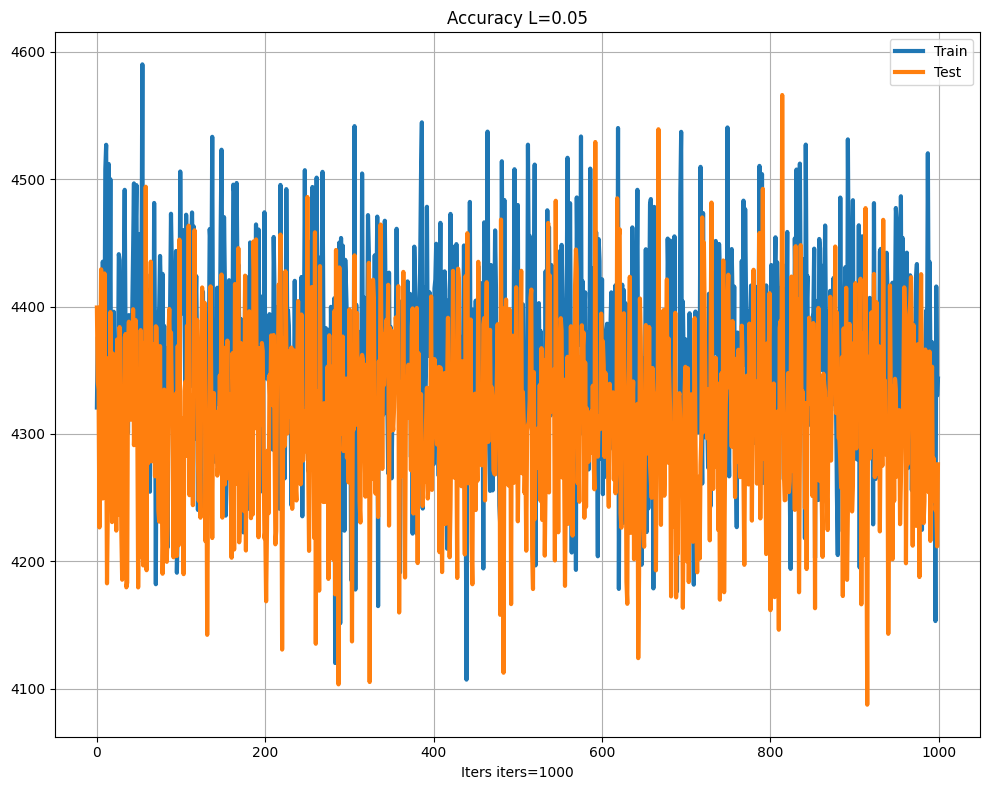

In [81]:
red_neuronal(L=0.05, epoch=iter,
                     w_hidden=w_hidden, w_output=w_output,
                     b_hidden=b_hidden, b_output=b_output,
                     relu=relu, logistic=logistic,
                     d_relu=d_relu, d_logistic=d_logistic)
calcular_accuracy()